# Pipeline
- 데이터 전처리, 특성 추출, 모델학습을 하나의 흐름으로 연결
- 사용 이유:
    - 코드 간결화: 여러 단계를 하나로 묶어 관리
    - 재현성 보장: 전체 프로세스를 일관되게 실행
    - 데이터 누수 방지: 교차 검증시 각 fold에서 독립적으로 전처리 가능
    - 하이퍼 파라미터 튜닝 용이: 전체 파이프라인에 대해서 GridSearch 적용

## Pipeline의 구성요소
- 변환기: 데이터를 변환하는 객체
    - `fit()`: 데이터에서 파라미터를 학습
    - `transfrom()`: 학습 파라미터로 데이터를 변환
    - StandardScaler, PCA, MinMaxSclaer ...
- 추정기: 머신러닝 모델
    - `fit()`: 데이터로 모델을 학습
    - `predict()`: 예측 수행
    - RandomForest, SVM ...

- 장점: 데이터 누수 방지

---



- `잘못된 예: 전체 데이터를 먼저 스케일링`

```python
x_scaed = scaler.fit_transform(x)
x_train,x_test = train_test_split(x_scaled)
model.fit(x_train,y_train)
```
문제: 테스트 데이터 정보가 스케일에 사용됨`

- `올바른 예: 학습데이터만으로 스케일링`
```python
x_train,x_test = train_test_split(x)
x_train_scaled = sclaer.fit_transform(x_train)
x_test_scaled = sclaer.transform(x_test) #fit없이 trainsfrom만
model.fit(x_train_scaled, y_train)
```

- `파이프라인 사용(BEST)`
```python
pipe.fit(x_train,y_train) # 학습 데이터만 fit
pipe.predict(x_test) # 테스트 데이터는 transform만
```
---

## k-겹 교차검증(K-Fold Cross-Validation)
- 홀드아웃: 데이터를 학습세트/테스트 세트 한 번만 분할
    - 전체데이터 100% -> 학습 70~80/테스트20~30
    - 장점: 빠르다, 대용량 데이터에 적합
    - 단점: 데이터 분할에 따라 성능이 크게 달라질 수 있음, 작은 데이터셋은 불안함, 일부 데이터만 학습에 사용
    - 언제사용?: 데이터가 충분히 많을 때(수만개 이상), 빠르게 평가할 때

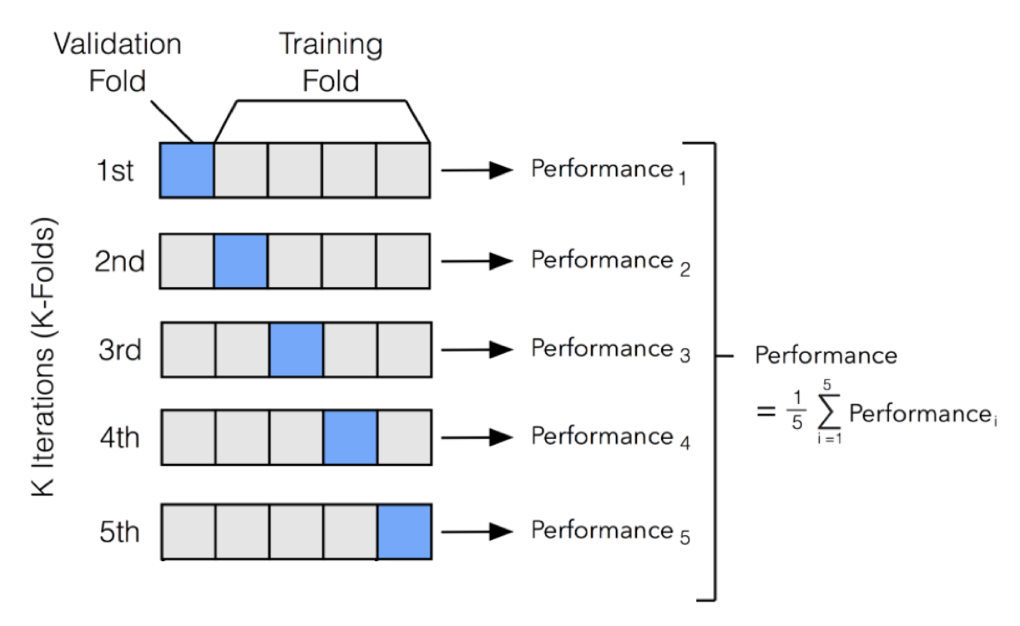

```
일반 k-fold
중화 stratified k-fold
```

---

## 학습곡선과 검증곡선
- 학습 데이터의 크기에 따른 모델 성능을 시각화
- 추세를 보고 모델 성능 개선 여부
- 데이터 편향
---

## GridSearch를 사용한 머신러닝 모델 세부 튜닝
- `파라미터`: 학습으로 찾은 값 (선형회귀 계수, 신경망의 가중치)
- `하이퍼파라미터`: 사람이 설정, 아직 정해지지 않은 값 (학습률, 정규화, 트리의 깊이...)
- 그리드서치: 모든 가능한 조합으로 체계적으로 시도 `param_grid = { ..}`
- 랜덤그리드서치: 모든 가능한 조합을 랜덤하게 (그리드서치는 다 함) <br>
-> 더 넓은 영역을 탐색(=파라미터 조합의 경우의 수) <br>
-> 시간제약이 있을 때<br>

언제사용?
- 그리드서치: 하이퍼파라미터 _2~3개_
- 랜덤그리드서치: 하이퍼파라미터 _4개 이상_
> <그리드서치>(9개 조합 모두 시도) <br>
> - A: 3개의 고유값 <br>
> - B: 3개의 고유값 <br>
>
> <랜덤그리드서치>(9개 중 3개 시도) <br>
> - `n_iter=3` <br>
> - 서로 다른 **최대** 9개의 값으로 시도 <br>
> - 중요한 파라미터에 더 많은 시도를 할 수 있음. -> 성능이 더 좋은 경우가 많다
---

### 파이프라인 구성

In [ ]:
# 파이프라인 구성
# LogisticRegression: 각 클래스에 대한 확률값 출력 -> 확률값이 큰 클래스타 선택됨 => 분류모델
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression 

pipe = Pipeline( [
    ('scaler',StandardScaler),
    ('pca',PCA(n_components=2)),
    ('classifier',LogisticRegression())
])

### 파이프라인 실행과정
- pipe.fit(x_train,y_train)
- StandardScaler x_train에 fit -> 평균과 표준편차 계산
- x_train을 표준화 -> x_scaled
- PCA가 x_scaled fit -> 주성분 계산
- x_scaled 변환 -> x_pca
- LogisticRegression이 x_pca fit

---

## 실습
데이터: 위스콘시 유방암 데이터 (대표적인 이진분류 데이터)
- 클래스: 2개(양성, 악성)
- 특성: 10개


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     StratifiedKFold, learning_curve, validation_curve,
                                     GridSearchCV, RandomizedSearchCV,
                                     cross_validate)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')

In [68]:
# section 1 : 위스콘신 유방암 데이터셋 로드 및 탐색
    # 데이터셋 구조 이해
    # 특성과 타겟의 관계 파악
    # 클래스 분포 확인
def section1_load_data():
    """
        데이터셋 구조 이해
        특성과 타겟의 관계 파악
        클래스 분포 확인
    """
    print("section 1 : 위스콘신 유방암 데이터셋")

    # 데이터 로드
    data = load_breast_cancer()
    X, y = data.data, data.target
    print("데이터셋 기본정보")
    print(f'샘플 수 : { X.shape[0] }')
    print(f'특성 수 : { X.shape[1] }')
    print(f'클래스 : {data.target_names}')
    # 클래스 분포
    unique, counts =  np.unique(y,return_counts=True)
    print("클래스분포")
    for label, count in zip(unique, counts):
        class_name = data.target_names[label]
        percentage = count / len(y) * 100
        print(f' {class_name} : {count}개 ({percentage:.1f}%)')
    # 특성 통계
    print("특성 통계 (처음 5개 특성)")
    df_lists = []
    for i in range(5):
        index_name = data.feature_names[i]
        stats = {
                'mean': X[:,i].mean(),
                    'std':X[:,i].std(),
                    'min':X[:,i].min(),
                    'max':X[:,i].max()
        }    
        df_lists.append(pd.DataFrame(stats,index = [index_name]))
    print(pd.concat(df_lists))
    return X, y, data

In [69]:
X,y,data = section1_load_data()

section 1 : 위스콘신 유방암 데이터셋
데이터셋 기본정보
샘플 수 : 569
특성 수 : 30
클래스 : ['malignant' 'benign']
클래스분포
 malignant : 212개 (37.3%)
 benign : 357개 (62.7%)
특성 통계 (처음 5개 특성)
                       mean         std        min        max
mean radius       14.127292    3.520951    6.98100    28.1100
mean texture      19.289649    4.297255    9.71000    39.2800
mean perimeter    91.969033   24.277619   43.79000   188.5000
mean area        654.889104  351.604754  143.50000  2501.0000
mean smoothness    0.096360    0.014052    0.05263     0.1634


In [78]:
def section2_basic_pipeline(X, y):
    """
    - Pipeline 객체생성
    - 표준화 + 모델 학습을 한번에 수행
    - 파이프라인의 장점을 이해
    """
    # 데이터 분할
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # 수동방식
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train_scaled, y_train)
    manual_score =  lr.score(X_test_scaled ,y_test )
    print(f'학습세트 크기 : {X_train.shape[0]}')
    print(f'테스트세트 크기 : {X_test.shape[0]}')
    print(f'테스트 정확도 : { manual_score:.4f}' )
    
    # 파이프라인
    pipe = Pipeline([
        ('scaler',StandardScaler() ),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])
    pipe.fit( X_train , y_train )
    pipeline_score = pipe.score( X_test, y_test )
    print(f'파이프라인 구조')
    for name,step in  pipe.steps:
        print(f' {name} : {step.__class__.__name__} ')
    
    print(f"테스트 정확도 : {pipeline_score:.4f}")
    print(f' 수동방식과 동일한 결과 : {np.isclose(manual_score, pipeline_score)}')

In [79]:
section2_basic_pipeline(X,y)

학습세트 크기 : 398
테스트세트 크기 : 171
테스트 정확도 : 0.9883
파이프라인 구조
 scaler : StandardScaler 
 classifier : LogisticRegression 
테스트 정확도 : 0.9883
 수동방식과 동일한 결과 : True


In [85]:
# 교차 검증 비교(홀드아웃 vs. k-fold)
    # 홀드아웃의 한계
    # k-fold 교차검증의 장점
    # 층화 k-fold의 중요성
def section3_cross_validation(X,y):
    pipe = Pipeline([
        ('sclaer',StandardScaler()),
        ('classifier',LogisticRegression(random_state=42, max_iter=1000))
    ])
    # 여러번 반복해서 불안정성 확인
    holdout_scores = []
    for i in range(10):
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)
        pipe.fit(X_train,y_train)
        holdout_score = pipe.score(X_test,y_test)
        holdout_scores.append(holdout_score)

        # 처음 3개만 출력
        if i < 3:
            print(f' {i+1} : {holdout_score:.4f}')
    
    print(f'홀드아웃 평균 : {np.mean(holdout_scores):.4f}, 표준편차 : {np.std(holdout_scores):.4f}')
    print(f'min : {np.min(holdout_scores)}   max : {np.max(holdout_scores)}')

    print('-'*100)
    # 5-겹 교차 검증
    cv_scores = cross_val_score(pipe,X,y,cv=5,scoring='accuracy')
    print('각 Fold의 점수')
    for i, score in enumerate(cv_scores,1):
        print(f' fold {i} : {score:.4f}')
    print(f'교차검증 평균 : {np.mean(cv_scores):.4f}  표준편차 : {np.std(cv_scores):.4f}')

    print('-'*100)
    # 층화 k 겹
    skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    stratified_scores = cross_val_score(pipe,X,y,cv=skf,scoring='accuracy')
    print('각 Fold의 점수')
    for i, score in enumerate(stratified_scores,1):
        print(f' fold {i} : {score:.4f}')
    print(f'층화 교차검증 평균 : {np.mean(stratified_scores):.4f}  표준편차 : {np.std(stratified_scores):.4f}')
    
    print('-'*100)
    # 각 fold의 클래스 분포 확인
    for i, (train_index, test_index) in enumerate(skf.split(X,y),1):
        y_fold =  y[test_index]
        unique,counts =  np.unique(y_fold, return_counts =True)
        ratio = counts[1] / len(y_fold) * 100
        print(f' fold {i} : 악성 {ratio:.1f}%')

    print('-'*100)
    # 결론
    print(f' 홀드아웃: 분할에 따라 성능차이가 크다. {np.std(holdout_scores):.4f}')
    print(f' k-fold: 더 안정적인 추정 {np.std(cv_scores):.4f}')
    print(f' 층화 k-fold: 클래스 비율유지 {np.std(stratified_scores):.4f}')


In [86]:
section3_cross_validation(X,y)

 1 : 0.9883
 2 : 0.9883
 3 : 0.9883
홀드아웃 평균 : 0.9883, 표준편차 : 0.0000
min : 0.9883040935672515   max : 0.9883040935672515
----------------------------------------------------------------------------------------------------
각 Fold의 점수
 fold 1 : 0.9825
 fold 2 : 0.9825
 fold 3 : 0.9737
 fold 4 : 0.9737
 fold 5 : 0.9912
교차검증 평균 : 0.9807  표준편차 : 0.0065
----------------------------------------------------------------------------------------------------
각 Fold의 점수
 fold 1 : 0.9737
 fold 2 : 0.9474
 fold 3 : 0.9649
 fold 4 : 0.9912
 fold 5 : 0.9912
층화 교차검증 평균 : 0.9737  표준편차 : 0.0166
----------------------------------------------------------------------------------------------------
 fold 1 : 악성 62.3%
 fold 2 : 악성 62.3%
 fold 3 : 악성 63.2%
 fold 4 : 악성 63.2%
 fold 5 : 악성 62.8%
----------------------------------------------------------------------------------------------------
 홀드아웃: 분할에 따라 성능차이가 크다. 0.0000
 k-fold: 더 안정적인 추정 0.0065
 층화 k-fold: 클래스 비율유지 0.0166


In [89]:
# section 4 : 학습곡선으로 편향-분산 분석
    # 학습곡선
    # 과소적합 / 과대적합 판단
    # 데이터 추가 필요성 판단

def section4_learning_curves(X,y):
    """
    - 학습곡선
    - 과소적합 / 과대적합 판단
    - 데이터 추가 필요성 판단
    """
    print('다양한 모델의 학습곡선 비교')
    models = [
        ('underfit\n(simple model)', 
         Pipeline([('sacler',StandardScaler()),('clf',LogisticRegression(C=0.01,max_iter = 1000))]) ),  # C는 규제강도

        ('normal\n(basic model)', 
         Pipeline([('sacler',StandardScaler()),('clf',LogisticRegression(C=1.0,max_iter = 1000))]) ),

        ('small overfit \n(complex model)', 
         Pipeline([('sacler',StandardScaler()),('clf',SVC(kernel='rbf',gamma='auto'))]) ),

        ('overfit\n(strong complex model)', 
         Pipeline([('sacler',StandardScaler()),('clf',DecisionTreeClassifier())]) ),
    ]
    fig, axes = plt.subplots(2,2,figsize=(15,12))

    for idx, (title, model) in enumerate(models):
        ax = axes[idx // 2, idx % 2] # (0, 0) (0, 1) (1, 0) (1, 1)
        # 학습곡선 계산
        train_sizes,train_score,test_score =          learning_curve(
            model,X,y,cv=5,
            train_sizes=np.linspace(0.1,1.0,10),
            scoring='accuracy',
            n_jobs=-1
        )
        # 평균과 표준편차
        train_mean = train_score.mean(axis=1)
        train_std =  train_score.std(axis=1)
        test_mean = test_score.mean(axis=1)
        test_std = test_score.std(axis=1)

        # 그래프 그리기
        ax.plot(train_sizes,train_mean, label='train score', marker='o', color='blue')
        ax.fill_between(train_sizes, train_mean - train_std, train_mean+train_std, alpha=0.15, color='blue')

        ax.plot(train_sizes,test_mean, label='test score', marker='s', color='red')
        ax.fill_between(train_sizes, test_mean - test_std, test_mean+test_std, alpha=0.15, color='red')

        ax.set_xlabel('train sample counts', fontsize=10)
        ax.set_ylabel('accuracy', fontsize=10)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0.5,1.05])

        # 최종성능 출력
        final_train = train_mean[-1]
        final_test = test_mean[-1]
        gap = final_train - final_test

        print(f' 최종 학습점수 : {final_train}')
        print(f' 최종 검증점수 : {final_test}')
        print(f' 점수차이 : {gap}')

        if gap < 0.05 and final_test < 0.85:
            print(' 진단 : 과소적합(높은 편향)')
            print(' 해결책 : 더 복잡한 모델 사용')
        elif gap > 0.15:
            print(' 진단 : 과대적합(높은 분산)')
            print(' 해결책 : 더 많은 데이터 수집 또는 정규화 증가')
        else:
            print(' 진단 : 적절한 적합')

다양한 모델의 학습곡선 비교
 최종 학습점수 : 0.9556043956043956
 최종 검증점수 : 0.9490607048594939
 점수차이 : 0.006543690744901687
 진단 : 적절한 적합
 최종 학습점수 : 0.9894505494505494
 최종 검증점수 : 0.9806862288464524
 점수차이 : 0.008764320604097042
 진단 : 적절한 적합
 최종 학습점수 : 0.9872527472527473
 최종 검증점수 : 0.9736376339077782
 점수차이 : 0.01361511334496901
 진단 : 적절한 적합
 최종 학습점수 : 1.0
 최종 검증점수 : 0.9138643067846607
 점수차이 : 0.08613569321533932
 진단 : 적절한 적합


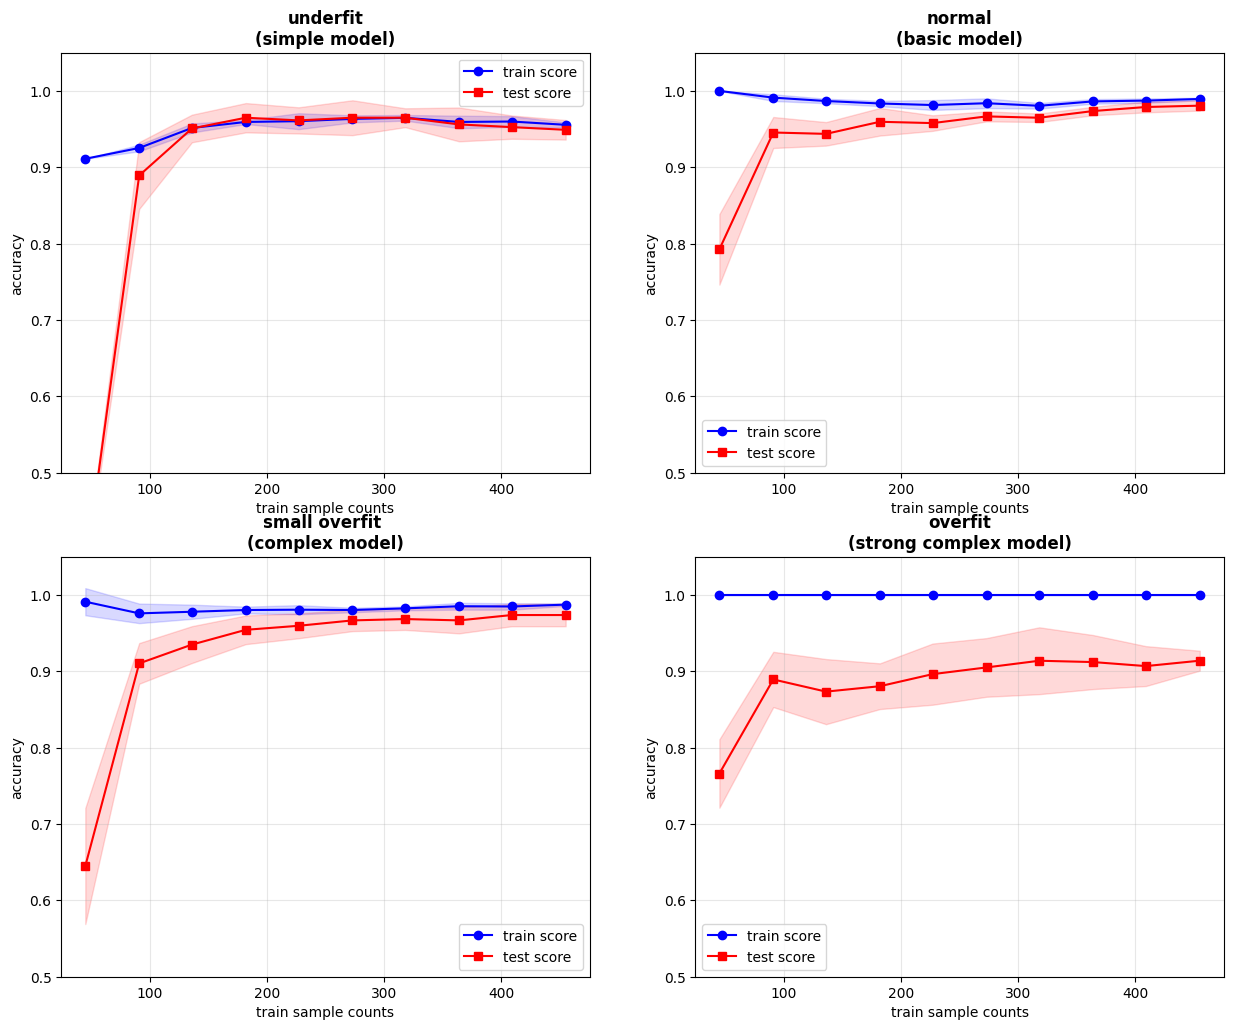

In [90]:
section4_learning_curves(X,y)

In [ ]:
# section 5 : 

fig,axes = plt.subplot(1,2,figsize=(15,5))
# LogisticRegression C 파라미터
print(f'LogisticRegression 정규화 파라미터 C')
print(f'( C가 적을수록 강한 정규화)')

pipe = Pipeline([
    ('sclaer',StandardScaler),
    ('clf',LogisticRegression(max_iter=1000))
])
param_range = np.logspace(-4,4,9) #0.0001 ~ 10000
validation_curve(
    pipe,X,y,
    param_name='clf_C'
    param_range=param_range,
    cv=3,
    scoring='accuracy'
    n_jobs=-1
)



## 다른 방법

In [ ]:
cancer = load_breast_cancer()
X_features = cancer.data
y_label = cancer.target

cancer_df = pd.DataFrame(data=X_features, columns=cancer.feature_names)
cancer_df['target']= y_label
cancer_df.head(3)

In [ ]:
print(cancer.target_names)
print(cancer_df['target'].value_counts())

In [ ]:
cancer_df.describe()

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_features,y_label,test_size=0.2,random_state=42)


